# Fokker-Planck Equation I: Advection

This notebooks looks at the functionality of the Fokker Planck integrator for the diffusion-free case, in which only advection is present in the dynamics. For th sake of simplicity, we look only at a one-dimensional scenario in this notebook.

Effectively, this means we will be simulating the dynamics of the equation

$$ \frac{\partial p(x, t)}{\partial t} = -\beta D \frac{\partial}{\partial x}\left[ F(x, t) p(x, t) \right] $$

Further, we will look specifically at the constant force case, where $F(x, t) = k$ so that the RHS of the equation is $-\beta D k \partial_x p(x, t)$

For a given initial condition $f(x)$, in such a situation the analytical solution to the advection equation is $f(x - vt)$ (as the advection equation is the wave equation) where the velocity of propagation is given by the prefactor of the derivative term, which, in this case, is $\beta D k$. For the sake of simplicity, we will take $\beta = D = 1$ in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
# The 1D integrator is contained in the Integrator module
from FPE import Integrator

# Define dynamics parameters
D = 1.0
dt = 0.001
dx = 0.001
force = 0.5
x_array = np.arange(-1, 1, dx)

# To start, initialize an integrator object,
fpe = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="periodic")

# And we can list the initialized instance variables for that object
fpe.__dict__.keys()



Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion



dict_keys(['D', 'dt', 'diffScheme', 'adScheme', 'BC', 'splitMethod', 'constDiff', 'output', 'sparseCalc', 'workAccumulator', 'workTracker', 'powerTracker', 'dx', 'N', 'prob', 'xArray', 'expImp', 'AMat', 'BMat', 'CMat', 'spaseCalc'])

In [2]:
# Now, we can initialize the system with a Gsassian distribution using hthe build-in initializer
init_var = 1 / 16
fpe.initializeProbability(0, init_var)


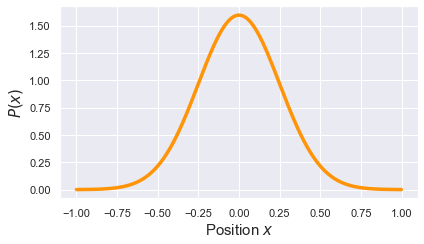

In [3]:
# We can plot the initial probably
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(fpe.xArray, fpe.prob, linewidth=3.5, color=sns.xkcd_rgb["tangerine"])
ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$P(x)$", fontsize=15)
plt.tight_layout()
plt.show()

In [4]:
# We can check the normalization by integrating, this is a probability
# density function, so \int p(x) dx = 1
import scipy.integrate as si

np.round(si.trapz(fpe.prob, fpe.xArray), 4)

1.0

In [5]:
# Now to simulate the advection, we cant ctually call any of the high-level
# integration routines, but we can simulate the advection-alone dynamics by
# accessing the _advection_step internal function. By default it makes use of
# the 2-step Lax-Wendroff algorithm to update the probability.

#To do this, however, we need to supply force parameters and a force function
# manually (typically, this could be globally set and then)
from FPE.forceFunctions import constantForce

# We also need to check the CFL criterion for these integration parameters
fpe.check_CFL([force], constantForce)

		CFL criterion satisfied, CFL --> 0.5




True

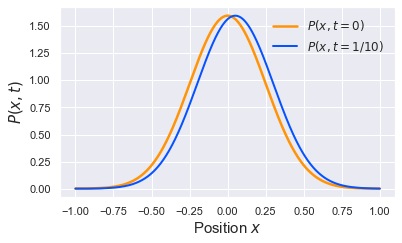

In [6]:
# So, the CFL is satisfied, so  we should be fine to run the dynamics

# This is a single step of the dynamics
fpe.initializeProbability(0, init_var)
init_prob = np.copy(fpe.prob)
# Now we can run the dynamics for time = 0.25
time = 0
total_time = 0.1
while time <= total_time:
    fpe.advectionUpdate([force], constantForce, fpe.dt)
    time += fpe.dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(fpe.xArray, init_prob, color=sns.xkcd_rgb["tangerine"], linewidth=2.5, label=r"$P(x, t=0)$")
ax.plot(fpe.xArray, fpe.prob, color=sns.xkcd_rgb["electric blue"], linewidth=2.0, label=r"$P(x, t=1/10)$")
ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$P(x, t)$", fontsize=15)
ax.legend(fontsize=12, frameon=False)

In [7]:
# We can calculate the distance that the mean of the distribution has moved as
# well to calculate the velocity of propagation

init_pos = fpe.xArray[np.argmax(init_prob)]
final_pos = fpe.xArray[np.argmax(fpe.prob)]
distance = final_pos - init_pos
velocity = distance / total_time
print(f"Velocity --> {np.round(velocity, 5)}")

Velocity --> 0.5


### Boundary Conditions

The discussion of boundary conditions for PDE integrators is technical in nature, as they are often the most difficult piece of the algorithm to get just right. This is because the behaviour on the boundaries is unque, and depends on the problem at hand. In general there are three types of boundary conditions in systems like those we are looking at:

* Closed
* Open
* Periodic

For advection alone, only two of these boundary conditions are applicable: open and periodic, as for hard-wall boundaries, there is no force that reflects the wave, so it becomes increasingly localised near the boundary, eventually breaking the discretization in the integrator. If we wanted to simulate reflecting wall conditions, then that would have to be included as a separate boundary condition (whihc is not currently implemented)

However, we can show how both open and periodic boundary conditions manifest in this simple advection-only constant-force setting. With reference to the previous figure, we expect that, for open boundaries, the travelling Gaussian wil simply move outn of the 'viewing region', and this can be tracked by observing the normalization condition over time. As the Gaussian wave moves out of the domain, the normalization equation will tend to zero. Converesely, in periodic boundary conditions, we expect that the Gaussian wave will pass out of the right side of the domain and enter on the left boundary, with the normalization staying at unity as the wave crosses the periodic boundary.

In the next few cells we will conclude our advection-only analysis by generating plots fo the time evolution of the Gaussian wave for both open and periodic boundary conditions.


In [8]:
# Instatiate the two different systems
fpe_periodic = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='periodic')
fpe_open = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='open')

fpe_periodic.initializeProbability(0, init_var)
fpe_open.initializeProbability(0, init_var)



Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion



Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion



In [9]:
force = 1.0
total_time = 2.0
time = 0
# We will track distributions at deltaT = 0.1 increments
counter = 0

time_tracker = []
density_periodic = []
density_open = []

while time < total_time:
    fpe_periodic.advectionUpdate([force], constantForce, fpe_periodic.dt)
    fpe_open.advectionUpdate([force], constantForce, fpe_periodic.dt)

    if counter % 100 == 0:
        time_tracker.append(time)
        density_periodic.append(np.copy(fpe_periodic.prob))
        density_open.append(np.copy(fpe_open.prob))

    counter += 1
    time += dt


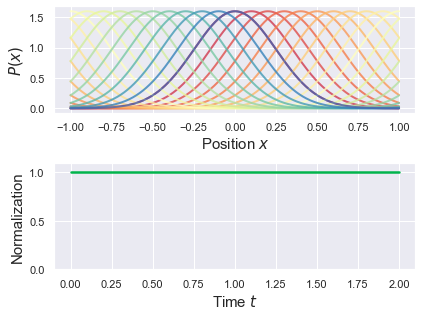

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4.5))
Pal = sns.color_palette("Spectral", len(density_periodic))
norm_tracker = []

dx = fpe_periodic.xArray[1] - fpe_periodic.xArray[0]

for i, density in enumerate(density_periodic):
    ax[0].plot(fpe_periodic.xArray, density, linewidth=2.0, color=Pal[i], alpha=0.8)
    norm_tracker.append(np.sum(density * dx))

ax[1].plot(time_tracker, norm_tracker, linewidth=2.5, color=sns.xkcd_rgb["shamrock"])
ax[1].set_ylim([0,1.1])

ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)

ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Normalization", fontsize=15)

plt.tight_layout()

### A note of caution

Previously I used the builtin `scipy.integrate.trapz` function to calcualte the normalization of the initial distribution. While simple in principle, using this for distributions that have significant support near the boundary could lead tosome head-scratching. Specifically, if we were to compare the normalization tracker from the previous cell as calculated using the `scipy` function our own calculation (`np.sum(density * dx)`) then we get the following figure (Note the change in $y$-scale here, made for clarity)

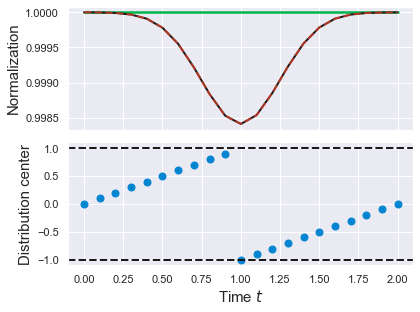

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True)

norm_tracker_scipy = []
norm_tracker_scipy_dx = []

# Array to track the position of the center of the distribution
distribution_center = []

for i, density in enumerate(density_periodic):
    distribution_center.append(fpe_periodic.xArray[np.argmax(density)])
    # We can specify an array of x-values OR a dx interval, both will give the
    # same result
    norm_tracker_scipy.append(si.trapz(density, fpe_periodic.xArray))
    norm_tracker_scipy_dx.append(si.trapz(density, dx=dx))

ax[0].plot(time_tracker, norm_tracker, linewidth=2.5, color=sns.xkcd_rgb["shamrock"])
ax[0].plot(time_tracker, norm_tracker_scipy, linewidth=2.0, color='k')
ax[0].plot(time_tracker, norm_tracker_scipy_dx, linewidth=2.0, color=sns.xkcd_rgb["tomato"], alpha=0.7, linestyle='--')

ax[1].plot(time_tracker, distribution_center, 'o', markersize=7, color=sns.xkcd_rgb["cerulean"])
ax[1].axhline(1, linestyle='--', color='k', linewidth=2.0)
ax[1].axhline(-1, linestyle='--', color='k', linewidth=2.0)

ax[0].set_ylabel(r"Normalization", fontsize=15)

ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Distribution center", fontsize=15)

plt.tight_layout()

So, here you can see that the `scipy` implementations of normalization tracking give errors when the distribution passes throguh the periodic boundary. Ultimately, this has to do with the way that the integral is calculated using the trapezoidal rule. More importantly, the normalization condition $\sum_i p_i \Delta x_i$ is the condition that we *want* to be fulfulled, as that is how the conservation rules are designed. This interpretation of the integral effectively takes the value of the probability to be known at $x_i$ and in a box of with $\Delta x_i$ around that point (we can interpret the normalization as a centered Riemann sum). So, in checking for conservation of normalization, the explicit form should be used.

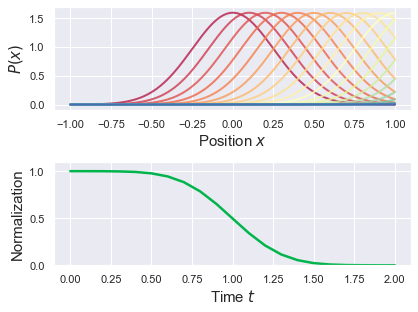

In [24]:
# Now lets look at the open boundary condition scenario

fig, ax = plt.subplots(2, 1, figsize=(6, 4.5))
Pal = sns.color_palette("Spectral", len(density_open))
norm_tracker = []

for i, density in enumerate(density_open):
    ax[0].plot(fpe_open.xArray, density, linewidth=2.0, color=Pal[i], alpha=0.8)
    norm_tracker.append(si.trapz(density, fpe_open.xArray))
ax[0].set_ylim([-0.1, 1.7])
ax[1].plot(time_tracker, norm_tracker, linewidth=2.5, color=sns.xkcd_rgb["shamrock"])
ax[1].set_ylim([0,1.1])


ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)

ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Normalization", fontsize=15)
plt.tight_layout()


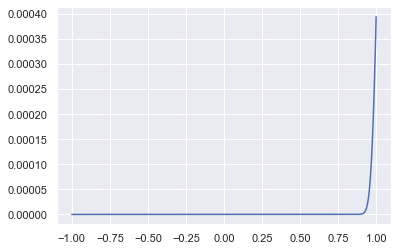

In [25]:
plt.plot(x_array, density_open[-1])
